# MTA Project 1: Data Cleaned

In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd

engine = create_engine("sqlite:///mta_data.db")
inspect(engine).get_table_names()

df = pd.read_sql('mta_data', engine)

### The data is meant to span Feb - May of 2018 - 2021 as a compromise, since the full years would have been too much to load into Jupyter.

In [2]:
#df.head()

### Analysis by various time groupings may be necessary, so "DATE" is converted to the proper format. Several derivatives of this are added to the table: month, year, day, day of week, and week. Station values are stripped for  comparison later.

In [2]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["MONTH"] = df["DATE"].dt.month
df["YEAR"] = df["DATE"].dt.year
df["DAY"] = df["DATE"].dt.day
df["WEEKDAY"] = df["DATE"].dt.dayofweek
df["WEEK"] = df["DATE"].dt.week
df["STATION"] = df["STATION"].str.strip()

/var/folders/ny/g82ykkn10bd8fqbx1q14fk_m0000gn/T/ipykernel_33857/398302139.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["WEEK"] = df["DATE"].dt.week


In [4]:
#df.head()

### df will now be modified to be sorted by station, turnstile, day, and time so we can create & apply the net entries & exits.

In [3]:
df = df.sort_values(["STATION","C/A","UNIT","SCP","DATE","TIME"],ascending=[True,True,True,True,False,False])

In [5]:
#df.head()

In [4]:
df["NET_ENTRIES"] = round(df["ENTRIES"].diff(-1))
df["NET_EXITS"] = round(df["EXITS"].diff(-1))

In [5]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,MONTH,YEAR,DAY,WEEKDAY,WEEK,NET_ENTRIES,NET_EXITS
32615,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,20:00:00,REGULAR,15570116,17823713,5,2021,28,4,21,230.0,370.0
32614,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,16:00:00,REGULAR,15569886,17823343,5,2021,28,4,21,175.0,470.0
32613,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,12:00:00,REGULAR,15569711,17822873,5,2021,28,4,21,71.0,710.0
32612,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,08:00:00,REGULAR,15569640,17822163,5,2021,28,4,21,18.0,464.0
32611,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,04:00:00,REGULAR,15569622,17821699,5,2021,28,4,21,14.0,49.0


### Playing around with views of that dataset revealed some inconsistencies that needs to be cleaned up. Negative entries will be converted to 0, along with anything over 10,000 turns in an hour. 
10,000 is a reasonable cutoff for excluding these calculations, as it represents 2,500 persons per hour passing through a turnstile, or 41 persons per minute. (https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0)

In [6]:
def fix_steps(x):
    if x < 0:
        return 0
    elif x > 10000:
        return 0
    else:
        return x
    
df["CLEAN_NET_ENTRIES"] = df["NET_ENTRIES"].apply(fix_steps)
df["CLEAN_NET_EXITS"] = df["NET_EXITS"].apply(fix_steps)

In [7]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,MONTH,YEAR,DAY,WEEKDAY,WEEK,NET_ENTRIES,NET_EXITS,CLEAN_NET_ENTRIES,CLEAN_NET_EXITS
32615,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,20:00:00,REGULAR,15570116,17823713,5,2021,28,4,21,230.0,370.0,230.0,370.0
32614,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,16:00:00,REGULAR,15569886,17823343,5,2021,28,4,21,175.0,470.0,175.0,470.0
32613,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,12:00:00,REGULAR,15569711,17822873,5,2021,28,4,21,71.0,710.0,71.0,710.0
32612,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,08:00:00,REGULAR,15569640,17822163,5,2021,28,4,21,18.0,464.0,18.0,464.0
32611,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,04:00:00,REGULAR,15569622,17821699,5,2021,28,4,21,14.0,49.0,14.0,49.0


### The 2nd to last modification ot the dataset will be creating a column summing the cleaned exit & entry data. This is good for looking at a station's overall activity. However, it should not be used to analyze overall rides since it would double everything.

In [8]:
df["CLEAN_ENT&EXIT"] = df["CLEAN_NET_ENTRIES"] + df["CLEAN_NET_EXITS"]

In [87]:
df = df.rename(columns={"CLEAN_ENT&EXIT":"CLEAN_NET_ENTS_N_EXITS"})

In [88]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,YEAR,DAY,WEEKDAY,WEEK,NET_ENTRIES,NET_EXITS,CLEAN_NET_ENTRIES,CLEAN_NET_EXITS,CLEAN_NET_ENTS_N_EXITS,STATION_OF_INTEREST
32615,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,20:00:00,REGULAR,15570116,...,2021,28,4,21,230.0,370.0,230.0,370.0,600.0,NaN
32614,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,16:00:00,REGULAR,15569886,...,2021,28,4,21,175.0,470.0,175.0,470.0,645.0,NaN
32613,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,12:00:00,REGULAR,15569711,...,2021,28,4,21,71.0,710.0,71.0,710.0,781.0,NaN
32612,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,08:00:00,REGULAR,15569640,...,2021,28,4,21,18.0,464.0,18.0,464.0,482.0,NaN
32611,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,04:00:00,REGULAR,15569622,...,2021,28,4,21,14.0,49.0,14.0,49.0,63.0,NaN


In [69]:
station_map = {"GRD CNTRL-42 ST":1,
    "TIMES SQ-42 ST":2,
    "42 ST-PORT AUTH":3,
    "WALL ST":4,
    "14 ST-UNION SQ":5,
    "34 ST-PENN STA":6,
    "161/YANKEE STAD":7,
    "METS-WILLETS PT":8,
    "ATL AV-BARCLAY":9,
    "BOTANIC GARDEN":10,
    "W 4 ST-WASH SQ":11,
    "CONEY IS-STILLW":12}
df["STATION_OF_INTEREST"] = df.STATION.map(station_map)

In [70]:
df.STATION_OF_INTEREST.unique()

array([nan,  5.,  7.,  6.,  3.,  9., 10., 12.,  1.,  8.,  2., 11.,  4.])

In [142]:
df.WEEKDAY.unique()

array([4, 3, 2, 1, 0, 6, 5])

In [143]:
weekday_proper = {6:"Sunday",0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday"}
df["WEEKDAY_PROPER"] = df.WEEKDAY.map(weekday_proper)

In [144]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,DAY,WEEKDAY,WEEK,NET_ENTRIES,NET_EXITS,CLEAN_NET_ENTRIES,CLEAN_NET_EXITS,CLEAN_NET_ENTS_N_EXITS,STATION_OF_INTEREST,WEEKDAY_PROPER
32615,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,20:00:00,REGULAR,15570116,...,28,4,21,230.0,370.0,230.0,370.0,600.0,NaN,Friday
32614,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,16:00:00,REGULAR,15569886,...,28,4,21,175.0,470.0,175.0,470.0,645.0,NaN,Friday
32613,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,12:00:00,REGULAR,15569711,...,28,4,21,71.0,710.0,71.0,710.0,781.0,NaN,Friday
32612,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,08:00:00,REGULAR,15569640,...,28,4,21,18.0,464.0,18.0,464.0,482.0,NaN,Friday
32611,H007,R248,00-00-00,1 AV,L,BMT,2021-05-28,04:00:00,REGULAR,15569622,...,28,4,21,14.0,49.0,14.0,49.0,63.0,NaN,Friday


#### Import matplotlib & seaborn before subset visualizations.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import numpy as np

In [38]:
from datetime import timedelta

## Subset #1: Annual Ride Changes

In [11]:
annual_df = df.groupby("YEAR").CLEAN_NET_ENTRIES.sum().reset_index()
annual_df

,YEAR,CLEAN_NET_ENTRIES
0,2018,586651366.0
1,2019,587638449.0
2,2020,271371233.0
3,2021,178478041.0


Text(0.5, 1.0, 'Total Subway Rides Feb - May')

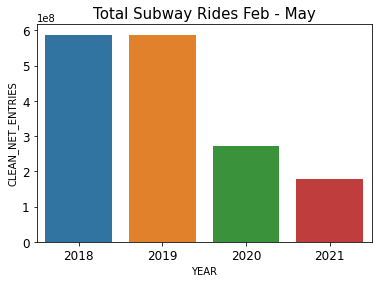

In [68]:
sns.barplot(x = "YEAR", y = "CLEAN_NET_ENTRIES",data = annual_df)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Total Subway Rides Feb - May",fontsize=15)

## Subset #2: Monthly & Annual Comparison

In [13]:
annual_mm_df = df.groupby(["YEAR","MONTH"]).CLEAN_NET_ENTRIES.sum().reset_index()
annual_mm_df = annual_mm_df[annual_mm_df["MONTH"]>1]

In [14]:
annual_mm_df

,YEAR,MONTH,CLEAN_NET_ENTRIES
1,2018,2,133196467.0
2,2018,3,150281562.0
3,2018,4,148639605.0
4,2018,5,131860649.0
6,2019,2,132269719.0
7,2019,3,150416186.0
8,2019,4,151847696.0
9,2019,5,125582221.0
11,2020,2,134259948.0
12,2020,3,75896647.0


Text(0.5, 1.0, 'Total Monthly Rides: Spring 2018 - 2021')

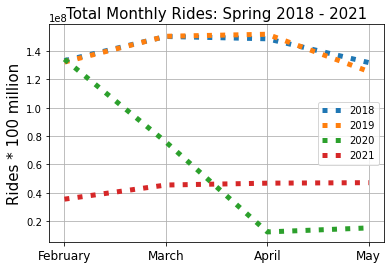

In [65]:
for i, group in annual_mm_df.groupby("YEAR"):
    plt.plot(group["MONTH"],group["CLEAN_NET_ENTRIES"], linewidth = 5, linestyle = ":")
     
plt.xticks(np.arange(2,6,1),["February","March","April","May"],fontsize=12)
plt.ylabel("Rides * 100 million",fontsize=15)
plt.legend([2018,2019,2020,2021])
plt.grid()
plt.title("Total Monthly Rides: Spring 2018 - 2021", fontsize=15)

In [70]:
#for i, group in annual_mm_df.groupby("YEAR"):
 #   plt.bar(group["MONTH"],group["CLEAN_NET_ENTRIES"])
     
#plt.xlabel("Month")
#plt.xticks(np.arange(2,6,1),["February","March","April","May"])
#plt.ylabel("Rides * 10 million")
#plt.legend([2018,2019,2020,2021]);
#figure(figsize = (4000,10))

## Subset #3: March - May of 2020 & 2021 to Juxtapose with COVID Data

In [16]:
mar_may_2020 = df[(df["YEAR"] == 2020) & ((df["MONTH"] == 3) | (df["MONTH"] == 4) | (df["MONTH"] == 5))].reset_index()
mar_may_2021 = df[(df["YEAR"] == 2021) & ((df["MONTH"] == 3) | (df["MONTH"] == 4) | (df["MONTH"] == 5))].reset_index()

In [17]:
mar_may_2020.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,...,MONTH,YEAR,DAY,WEEKDAY,WEEK,NET_ENTRIES,NET_EXITS,CLEAN_NET_ENTRIES,CLEAN_NET_EXITS,CLEAN_ENT&EXIT
0,3587047,H007,R248,00-00-00,1 AV,L,BMT,2020-05-29,20:00:00,REGULAR,...,5,2020,29,4,22,0.0,2.0,0.0,2.0,2.0
1,3587046,H007,R248,00-00-00,1 AV,L,BMT,2020-05-29,16:00:00,REGULAR,...,5,2020,29,4,22,0.0,3.0,0.0,3.0,3.0
2,3587045,H007,R248,00-00-00,1 AV,L,BMT,2020-05-29,12:00:00,REGULAR,...,5,2020,29,4,22,0.0,0.0,0.0,0.0,0.0
3,3587044,H007,R248,00-00-00,1 AV,L,BMT,2020-05-29,08:00:00,REGULAR,...,5,2020,29,4,22,0.0,4.0,0.0,4.0,4.0
4,3587043,H007,R248,00-00-00,1 AV,L,BMT,2020-05-29,04:00:00,REGULAR,...,5,2020,29,4,22,0.0,0.0,0.0,0.0,0.0


In [18]:
mar_may_2020_date = pd.DataFrame(mar_may_2020.groupby("DATE").CLEAN_NET_ENTRIES.sum().reset_index())

(0.0, 6000000.0)

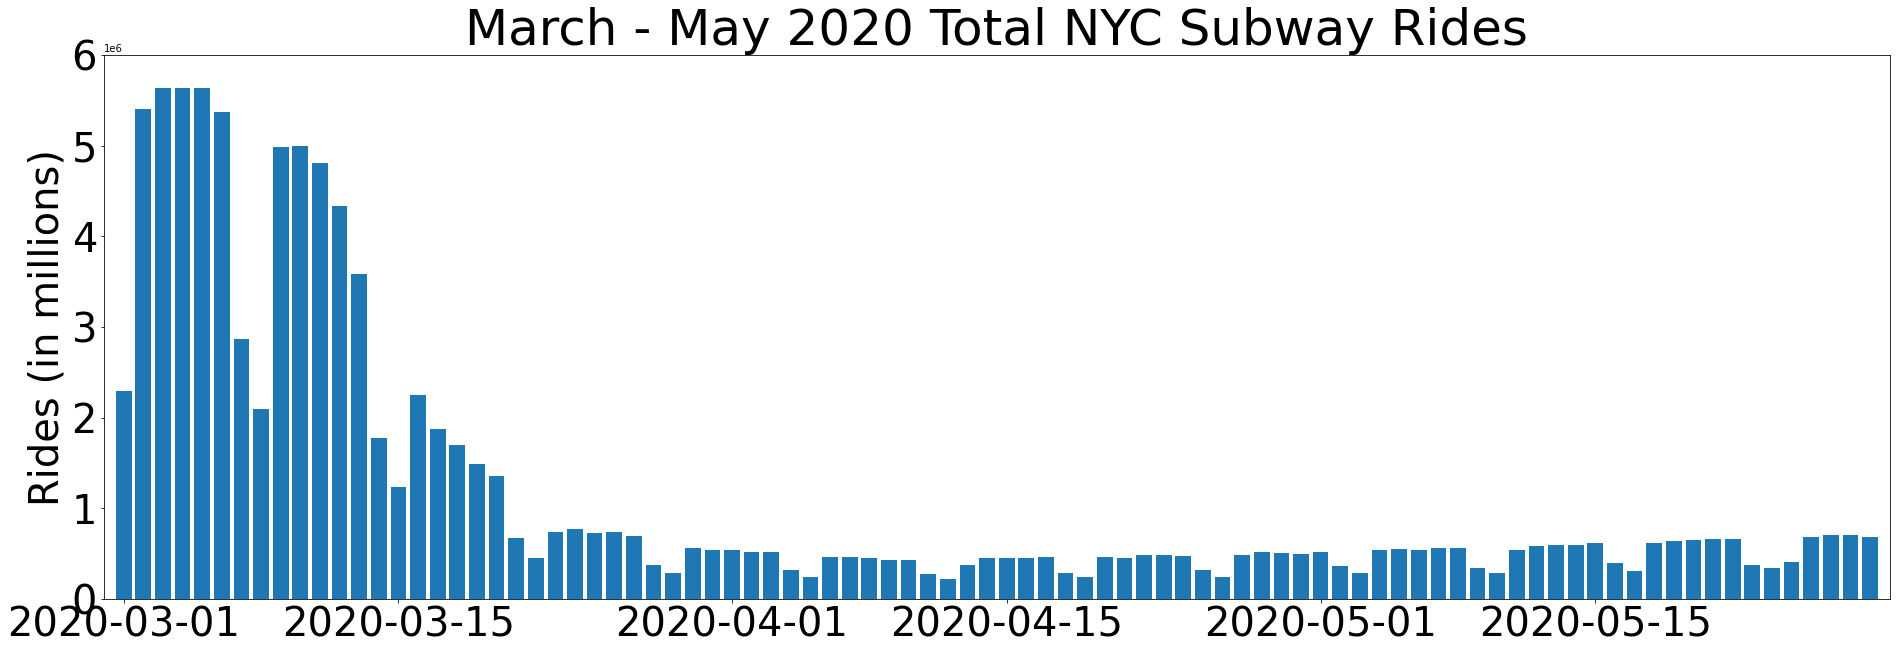

In [50]:
figure(figsize=(32,10))
plt.bar(mar_may_2020_date["DATE"], mar_may_2020_date["CLEAN_NET_ENTRIES"])
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title("March - May 2020 Total NYC Subway Rides",fontsize=50)
plt.ylabel("Rides (in millions)",fontsize=40)
plt.xlim(mar_may_2020_date["DATE"].min()-timedelta(days=1), mar_may_2020_date["DATE"].max()+timedelta(days=1))
plt.ylim(0,6000000)

In [20]:
mar_may_2020_date

,DATE,CLEAN_NET_ENTRIES
0,2020-03-01,2296070.0
1,2020-03-02,5411090.0
2,2020-03-03,5636019.0
3,2020-03-04,5640040.0
4,2020-03-05,5632519.0
...,...,...
85,2020-05-25,410515.0
86,2020-05-26,677387.0
87,2020-05-27,704436.0
88,2020-05-28,702456.0


In [25]:
mar_may_2021_date = pd.DataFrame(mar_may_2021.groupby("DATE").CLEAN_NET_ENTRIES.sum().reset_index())

(0.0, 6000000.0)

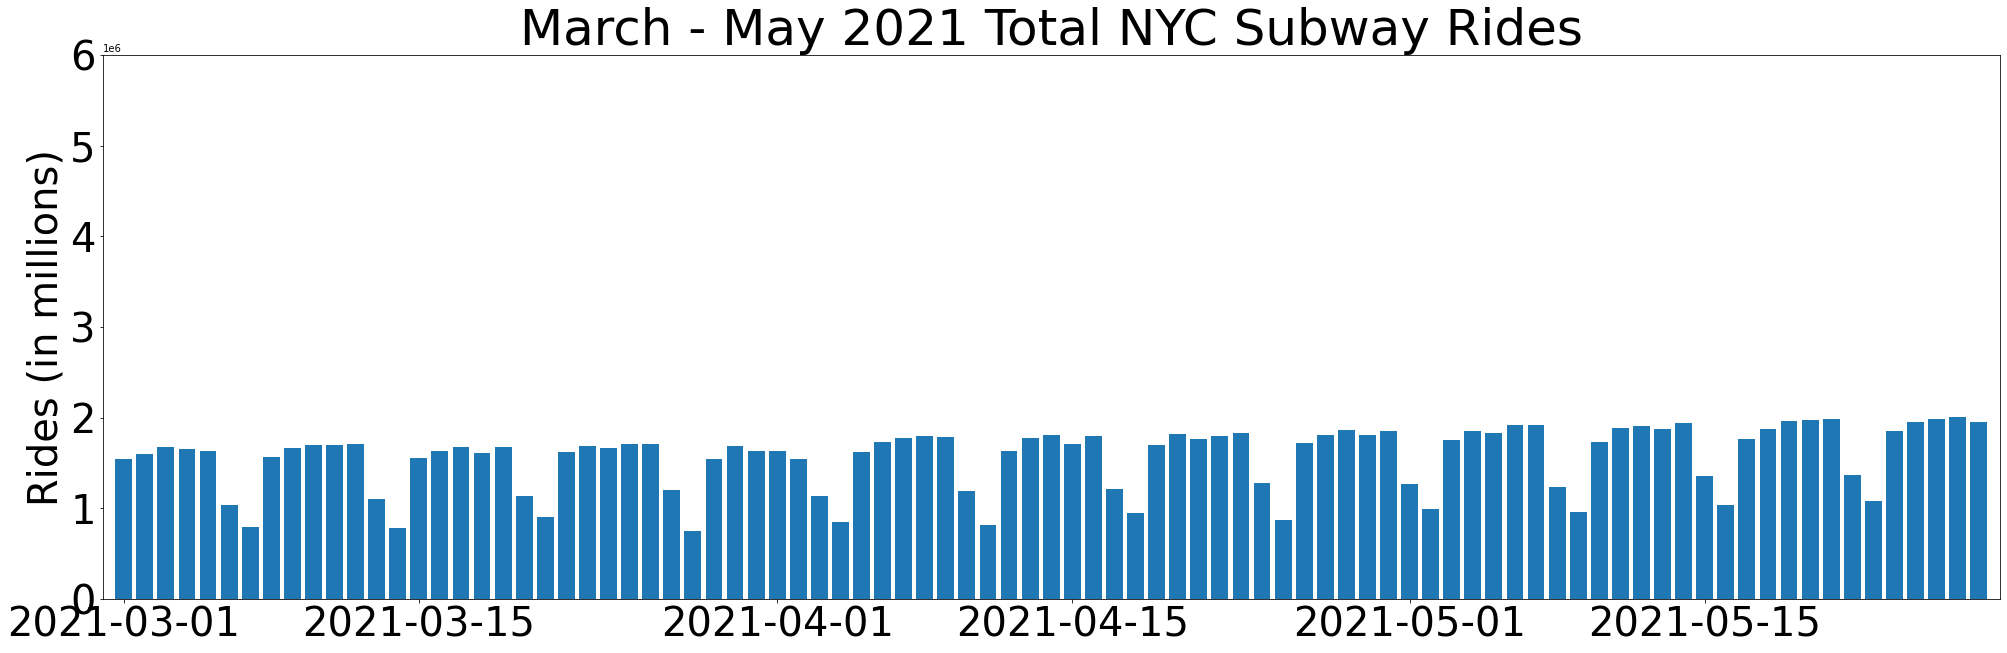

In [51]:
figure(figsize=(34,10))
plt.bar(mar_may_2021_date["DATE"], mar_may_2021_date["CLEAN_NET_ENTRIES"])
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title("March - May 2021 Total NYC Subway Rides",fontsize=50)
plt.ylabel("Rides (in millions)",fontsize=40)
plt.xlim(mar_may_2021_date["DATE"].min()-timedelta(days=1), mar_may_2021_date["DATE"].max()+timedelta(days=1))
plt.ylim(0,6000000)

In [ ]:
mar_may_2019_date = pd.DataFrame(mar_may_2019.groupby("DATE").CLEAN_NET_ENTRIES.sum().reset_index())

### I do not have the ability to insert images in a jupyter cell, but in the presentation hope to use a screenshot of  monthly new COVID cases to compare to the 2020 & 2021 monthly ridership changes. 
The source will be https://news.google.com/covid19/map?hl=en-US&mid=%2Fm%2F02_286&gl=US&ceid=US%3Aen&state=1.

### Subset #4: Stations of Interest
Hre we single out 12 stations of particular interest, either as transportation hubs and/or sports arena stops, as well as a couple parks.  

In [89]:
stations_df = df.loc[df["STATION_OF_INTEREST"].notnull(),df.columns]

In [90]:
stations_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,YEAR,DAY,WEEKDAY,WEEK,NET_ENTRIES,NET_EXITS,CLEAN_NET_ENTRIES,CLEAN_NET_EXITS,CLEAN_NET_ENTS_N_EXITS,STATION_OF_INTEREST
4929,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2021-05-28,21:00:00,REGULAR,378742,...,2021,28,4,21,74.0,190.0,74.0,190.0,264.0,5.0
4928,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2021-05-28,17:00:00,REGULAR,378668,...,2021,28,4,21,104.0,350.0,104.0,350.0,454.0,5.0
4927,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2021-05-28,13:00:00,REGULAR,378564,...,2021,28,4,21,21.0,286.0,21.0,286.0,307.0,5.0
4926,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2021-05-28,09:00:00,REGULAR,378543,...,2021,28,4,21,2.0,157.0,2.0,157.0,159.0,5.0
4925,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2021-05-28,05:00:00,REGULAR,378541,...,2021,28,4,21,5.0,11.0,5.0,11.0,16.0,5.0


In [91]:
stations_df = stations_df.sort_values(["STATION_OF_INTEREST","C/A","UNIT","SCP","DATE","TIME"],
                                      ascending=[True, True, True, True, False,False])

In [92]:
stations_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,YEAR,DAY,WEEKDAY,WEEK,NET_ENTRIES,NET_EXITS,CLEAN_NET_ENTRIES,CLEAN_NET_EXITS,CLEAN_NET_ENTS_N_EXITS,STATION_OF_INTEREST
368704,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,2021-05-18,09:56:43,REGULAR,71,...,2021,18,1,20,0.0,4.0,0.0,4.0,4.0,1.0
368703,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,2021-05-17,21:00:00,REGULAR,71,...,2021,17,0,20,0.0,0.0,0.0,0.0,0.0,1.0
368702,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,2021-05-17,17:00:00,REGULAR,71,...,2021,17,0,20,0.0,1.0,0.0,1.0,1.0,1.0
368701,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,2021-05-17,13:00:00,REGULAR,71,...,2021,17,0,20,0.0,0.0,0.0,0.0,0.0,1.0
368700,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,2021-05-17,09:00:00,REGULAR,71,...,2021,17,0,20,0.0,1.0,0.0,1.0,1.0,1.0


In [100]:
stations_df_yr = pd.DataFrame(stations_df.groupby(["STATION_OF_INTEREST","STATION","YEAR"]).CLEAN_NET_ENTS_N_EXITS.sum().reset_index())

In [101]:
stations_df_yr

,STATION_OF_INTEREST,STATION,YEAR,CLEAN_NET_ENTS_N_EXITS
0,1.0,GRD CNTRL-42 ST,2018,27684536.0
1,1.0,GRD CNTRL-42 ST,2019,28434090.0
2,1.0,GRD CNTRL-42 ST,2020,11533766.0
3,1.0,GRD CNTRL-42 ST,2021,6127023.0
4,2.0,TIMES SQ-42 ST,2018,19778095.0
5,2.0,TIMES SQ-42 ST,2019,20047478.0
6,2.0,TIMES SQ-42 ST,2020,8244699.0
7,2.0,TIMES SQ-42 ST,2021,4463584.0
8,3.0,42 ST-PORT AUTH,2018,17499169.0
9,3.0,42 ST-PORT AUTH,2019,18037211.0


In [128]:
MAX = stations_df_yr.CLEAN_NET_ENTS_N_EXITS.max()
MAX

32981639.0

In [127]:
MIN = stations_df_yr.CLEAN_NET_ENTS_N_EXITS.min()

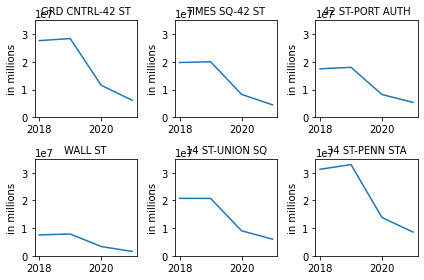

In [136]:
#sns.barplot(x = "YEAR", y = "CLEAN_NET_ENTRIES",data = annual_df)
for val in np.arange(1,7,1):
    db_val = stations_df_yr.loc[stations_df_yr["STATION_OF_INTEREST"]==val,stations_df_yr.columns]
    plt.subplot(2,3,val)
    plt.plot(db_val['YEAR'],db_val["CLEAN_NET_ENTS_N_EXITS"])
    plt.tight_layout()
    plt.title(db_val.iloc[1,1],fontsize=10)
    plt.ylim(0,35000000)
    plt.ylabel("in millions")


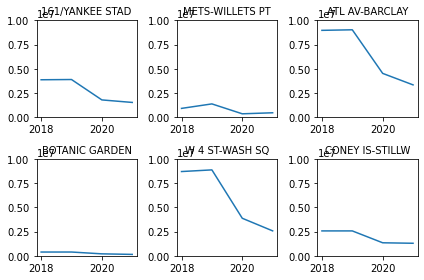

In [135]:
for val in np.arange(7,13,1):
    db_val = stations_df_yr.loc[stations_df_yr["STATION_OF_INTEREST"]==val,stations_df_yr.columns]
    plt.subplot(2,3,val-6)
    plt.plot(db_val['YEAR'],db_val["CLEAN_NET_ENTS_N_EXITS"])
    plt.tight_layout()
    plt.title(db_val.iloc[1,1],fontsize=10)
    plt.ylim(0,10000000)
